In [1]:
import deepsurvk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk

from sksurv.metrics import (
    concordance_index_ipcw,
    concordance_index_censored,
    brier_score,
    cumulative_dynamic_auc
)

C:\Users\harri\anaconda3\envs\deepsurv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

In [3]:
train = pd.read_csv("train.csv",index_col = 0)
#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)



y = train[["event_observed","event_max" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)
test = pd.read_csv("test.csv",index_col = 0)

X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["event_observed","event_max" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [4]:
n_features = X_train.shape[1]
n_batch = X_train.shape[0]

In [5]:
activation = 'relu'
n_nodes = 48
learning_rate = 0.067
l2_reg = 16.094
dropout = 0.147
lr_decay =  6.494e-4
momentum = 0.863

In [6]:
def negative_log_likelihood(E):
    def loss(y_true, y_pred):
        
        hazard_ratio = tf.math.exp(y_pred)        
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)

        # TODO
        # For some reason, adding num_observed_events does not work.
        # Therefore, for now we will use it as a simple factor of 1.
        # Is it really needed? Isn't it just a scaling factor?
        # num_observed_events = tf.math.cumsum(E)
        # num_observed_events = tf.cast(num_observed_events, dtype=tf.float32)
        num_observed_events = tf.constant(1, dtype=tf.float32)
        
        neg_likelihood = neg_likelihood_ / num_observed_events        
        
        return neg_likelihood
    
    return loss

In [7]:
# Create model
model = Sequential()
model.add(Dense(units=n_features, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(ActivityRegularization(l2=l2_reg))

# Define the optimizer
# Nadam is Adam + Nesterov momentum
# optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay, clipnorm=1) 
optimizer = Nadam(learning_rate=learning_rate, weight_decay=lr_decay)

# Compile the model and show a summary of it
model.compile(loss=negative_log_likelihood(y_train["event_observed"]), optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 94)                8930      
                                                                 
 dropout (Dropout)           (None, 94)                0         
                                                                 
 dense_1 (Dense)             (None, 48)                4560      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4

from sklearn.preprocessing import StandardScaler


whasX_train, whasY_train, whasE_train, = load_whas(partition='training', data_type='np')
X_scaler = StandardScaler().fit(whasX_train)
whasX_train = X_scaler.transform(whasX_train)

Y_scaler = StandardScaler().fit(whasY_train.reshape(-1, 1))
whasY_train = Y_scaler.transform(whasY_train)
whasY_train = whasY_train.flatten()


In [8]:
from sklearn.preprocessing import StandardScaler


X_scaler = StandardScaler().fit(X_train)
X_train_scale = X_scaler.transform(X_train)

Y_scaler = StandardScaler().fit(y_train["event_max"].reshape(-1, 1))
y_train_scale = Y_scaler.transform(y_train["event_max"].reshape(-1, 1))
y_train_scale = y_train_scale.flatten()

In [9]:
callbacks = [tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.EarlyStopping(monitor='loss',patience=10,start_from_epoch=10,verbose=1)]
             #tf.keras.callbacks.ModelCheckpoint(str(PATH_MODELS/f'{example_file}.h5'), monitor='loss', save_best_only=True, mode='min')]

In [10]:
epochs = 50
history = model.fit(X_train_scale, y_train_scale, 
                    batch_size=n_batch, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    shuffle=True)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 76923712.0000
Epoch 2/50
1/1 [==============================] - 0s 339ms/step - loss: 77672376.0000
Epoch 3/50
1/1 [==============================] - 0s 326ms/step - loss: 77165440.0000
Epoch 4/50
1/1 [==============================] - 0s 354ms/step - loss: 76314952.0000
Epoch 5/50
1/1 [==============================] - 0s 353ms/step - loss: 76624432.0000
Epoch 6/50
1/1 [==============================] - 0s 344ms/step - loss: 76251776.0000
Epoch 7/50
1/1 [==============================] - 0s 357ms/step - loss: 76276168.0000
Epoch 8/50
1/1 [==============================] - 0s 368ms/step - loss: 76153104.0000
Epoch 9/50
1/1 [==============================] - 0s 354ms/step - loss: 76091432.0000
Epoch 10/50
1/1 [==============================] - 0s 349ms/step - loss: 76146104.0000
Epoch 11/50
1/1 [==============================] - 0s 357ms/step - loss: 76097720.0000
Epoch 12/50
1/1 [==============================] - 0s 3

Text(0, 0.5, 'Loss [u.a.]')

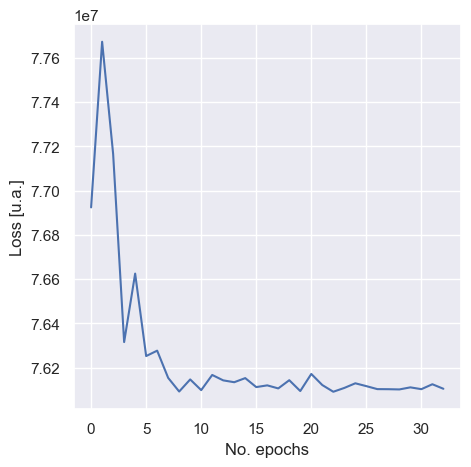

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plt.plot(history.history['loss'], label='train')
ax.set_xlabel("No. epochs")
ax.set_ylabel("Loss [u.a.]")

In [19]:
X_test_scale = X_scaler.transform(X_test)
y_predict = model.predict(X_test_scale)

101/101 [==============================] - 0s 805us/step


In [14]:
Y_scaler.inverse_transform(y_predict)

array([[307.40427],
       [305.4741 ],
       [305.10483],
       ...,
       [305.82242],
       [305.36047],
       [306.1158 ]], dtype=float32)

In [22]:
concordance_index_ipcw(y_train,y_test,Y_scaler.inverse_transform(y_predict).flatten(),tau=365)

(0.46592371942199623, 148019, 185199, 444, 1754)